<a href="https://colab.research.google.com/github/Zahra2351373/Image-Processing-Final-Project/blob/Master/Experiment%209.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing Libraries
Firstly, necessary libraries including OpenCV for image processing tasks, and convolution layer and max pool for implementing contracting path must be imported. An input layer is needed for feeding images to the network. Also transposed and concatenation layers are critical for implementing expansive and connection paths respectively. Matplotlib is critical for sowing graphs and images.

In [1]:
import cv2
import glob
import os
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Input 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model
from PIL import Image
from tensorflow import keras
from PIL import ImageSequence
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import SGD

In [2]:
url = "https://github.com/hasibzunair/cu-comp478-lab/releases/download/v0.0.1/LUNGS_images.npy"
filename = os.path.join(os.getcwd(), "LUNGS_images.npy")
keras.utils.get_file(filename, url)

url = "https://github.com/hasibzunair/cu-comp478-lab/releases/download/v0.0.1/LUNGS_mask.npy"
filename = os.path.join(os.getcwd(), "LUNGS_mask.npy")
keras.utils.get_file(filename, url)

267657216/267649152 [==============================] - 7s 0us/step


'/content/LUNGS_mask.npy'

In [18]:
datas = np.load("LUNGS_images.npy") 
labels = np.load("LUNGS_mask.npy")
print(datas.shape, labels.shape)

(1021, 256, 256, 1) (1021, 256, 256, 1)



#Defining Image size
Image size and channels must be defined and 1 relates to the grayscale image.

In [19]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 1
IMG_SIZE=(256,256)


#Dividing Data
I used the scikit-learn library for train-test-split to use 30% of data for validation as my dataset does not have validation images and I have to use a part of my data for validation, and 70% of my data for training my model. The random state is a parameter that is initialized to 0 in most of the deep neural networks.

In [20]:
x_train, x_test, y_train, y_test = train_test_split(
    datas, labels,test_size=0.3, random_state=0)

print("train_data: ", x_train.shape)
print("train_label: ", y_train.shape)
print("test_data: ",  x_test.shape)
print("test_label: ", y_test.shape)

train_data:  (714, 256, 256, 1)
train_label:  (714, 256, 256, 1)
test_data:  (307, 256, 256, 1)
test_label:  (307, 256, 256, 1)


 I divided my image and labels into 255(maximum number of pixels for an image= 2^8 - 1) to prevent huge computations in convolutions and loss information, that is why it is better that input numbers are normalized and their values are between 0 and 1.

In [21]:
input_layer = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
normalized_input = tf.keras.layers.Lambda(lambda x: x / 255)(input_layer)


#Building Model
I defined my model using tf.keras.layers. The difference between my implementation and the original U-Net implementation is in the original paper the images are in the size of 572x572 but I resized to 256x256 to decrease computations.The activation function based on the original U-Net paper is relu and as I do not want to apply padding that is why the padding is the same here. The U-Net is not a sequential model and it contains the skip connections path, that is why I have to use concatenation. Dropout layer is necessary to avoid overfitting. 

In [22]:
convolution1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(normalized_input)
convolution1 = tf.keras.layers.Dropout(0.1)(convolution1)
convolution1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(convolution1)
pooling1 = tf.keras.layers.MaxPooling2D((2, 2))(convolution1)

convolution2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pooling1)
convolution2 = tf.keras.layers.Dropout(0.1)(convolution2)
convolution2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(convolution2)
pooling2 = tf.keras.layers.MaxPooling2D((2, 2))(convolution2)
  
convolution3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pooling2)
convolution3 = tf.keras.layers.Dropout(0.1)(convolution3)
convolution3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(convolution3)
pooling3 = tf.keras.layers.MaxPooling2D((2, 2))(convolution3)
  
convolution4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pooling3)
convolution4 = tf.keras.layers.Dropout(0.1)(convolution4)
convolution4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(convolution4)
pooling4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(convolution4)
  
convolution5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pooling4)
convolution5 = tf.keras.layers.Dropout(0.2)(convolution5)
convolution5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(convolution5)

up6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(convolution5)
up6 = tf.keras.layers.concatenate([up6, convolution4])
convolution6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up6)
convolution6 = tf.keras.layers.Dropout(0.2)(convolution6)
convolution6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(convolution6)
  
up7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(convolution6)
up7 = tf.keras.layers.concatenate([up7, convolution3])
convolution7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up7)
convolution7 = tf.keras.layers.Dropout(0.2)(convolution7)
convolution7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(convolution7)
  
up8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(convolution7)
up8 = tf.keras.layers.concatenate([up8, convolution2])
convolution8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up8)
convolution8 = tf.keras.layers.Dropout(0.2)(convolution8)
convolution8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(convolution8)
  
up9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(convolution8)
up9 = tf.keras.layers.concatenate([up9, convolution1], axis=3)
convolution9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up9)
convolution9 = tf.keras.layers.Dropout(0.1)(convolution9)
convolution9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(convolution9)
  
output_layer = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(convolution9)
  
model = tf.keras.Model(inputs=[input_layer], outputs=[output_layer])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 256, 1)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 256, 256, 16) 160         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 256, 256, 16) 0           conv2d_19[0][0]                  
____________________________________________________________________________________________

In [23]:
def u_net(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):

  convolution1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(normalized_input)
  convolution1 = tf.keras.layers.Dropout(0.1)(convolution1)
  convolution1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(convolution1)
  pooling1 = tf.keras.layers.MaxPooling2D((2, 2))(convolution1)

  convolution2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pooling1)
  convolution2 = tf.keras.layers.Dropout(0.1)(convolution2)
  convolution2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(convolution2)
  pooling2 = tf.keras.layers.MaxPooling2D((2, 2))(convolution2)
  
  convolution3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pooling2)
  convolution3 = tf.keras.layers.Dropout(0.1)(convolution3)
  convolution3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(convolution3)
  pooling3 = tf.keras.layers.MaxPooling2D((2, 2))(convolution3)
  
  convolution4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pooling3)
  convolution4 = tf.keras.layers.Dropout(0.1)(convolution4)
  convolution4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(convolution4)
  pooling4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(convolution4)
  
  convolution5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pooling4)
  convolution5 = tf.keras.layers.Dropout(0.2)(convolution5)
  convolution5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(convolution5)

  up6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(convolution5)
  up6 = tf.keras.layers.concatenate([up6, convolution4])
  convolution6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up6)
  convolution6 = tf.keras.layers.Dropout(0.2)(convolution6)
  convolution6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(convolution6)
  
  up7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(convolution6)
  up7 = tf.keras.layers.concatenate([up7, convolution3])
  convolution7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up7)
  convolution7 = tf.keras.layers.Dropout(0.2)(convolution7)
  convolution7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(convolution7)
  
  up8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(convolution7)
  up8 = tf.keras.layers.concatenate([up8, convolution2])
  convolution8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up8)
  convolution8 = tf.keras.layers.Dropout(0.2)(convolution8)
  convolution8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(convolution8)
  
  up9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(convolution8)
  up9 = tf.keras.layers.concatenate([up9, convolution1], axis=3)
  convolution9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up9)
  convolution9 = tf.keras.layers.Dropout(0.1)(convolution9)
  convolution9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(convolution9)
  
  output_layer = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(convolution9)
  
  model = tf.keras.Model(inputs=[input_layer], outputs=[output_layer])
  model.summary()

  
    
  return model


#Compiling Model
I compiled my model using SGD optimizer and binary-crossentropy loss function.

In [24]:
model.compile(
    optimizer=SGD(lr=0.01,momentum=0.99),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [25]:
history = model.fit(x_train, y_train,
                batch_size=8,
                epochs=10,
                validation_data=(x_test, y_test))

Epoch 1/10
90/90 [==============================] - 9s 86ms/step - loss: 0.5277 - accuracy: 0.7526 - val_loss: 0.3808 - val_accuracy: 0.8436
Epoch 2/10
90/90 [==============================] - 7s 83ms/step - loss: 0.3869 - accuracy: 0.8365 - val_loss: 0.2336 - val_accuracy: 0.9264
Epoch 3/10
90/90 [==============================] - 8s 84ms/step - loss: 0.1336 - accuracy: 0.9662 - val_loss: 0.0580 - val_accuracy: 0.9795
Epoch 4/10
90/90 [==============================] - 8s 86ms/step - loss: 0.0649 - accuracy: 0.9778 - val_loss: 0.0616 - val_accuracy: 0.9740
Epoch 5/10
90/90 [==============================] - 8s 85ms/step - loss: 0.0320 - accuracy: 0.9887 - val_loss: 0.0339 - val_accuracy: 0.9871
Epoch 6/10
90/90 [==============================] - 8s 84ms/step - loss: 0.0243 - accuracy: 0.9911 - val_loss: 0.0184 - val_accuracy: 0.9932
Epoch 7/10
90/90 [==============================] - 8s 84ms/step - loss: 0.0185 - accuracy: 0.9933 - val_loss: 0.0191 - val_accuracy: 0.9933
Epoch 8/10
90

Binarize output as the model output values must be between 0 and 1.

In [26]:
res = None
res= model.predict(x=x_test, batch_size=8)
res = np.round(res,0)


#Results
I used matplotlib for showing my results.

In [27]:
def visualize_predictions(image):
    
    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1)
    plt.imshow(x_test[image,:,:,0], cmap='gray')
    plt.title('Input Image')
    plt.subplot(1,3,2)
    plt.imshow(y_test[image,:,:,0], cmap='gray')
    plt.yticks([])
    plt.title('Ground Truth')
    plt.subplot(1,3,3)
    plt.imshow(res[image,:,:,0], cmap='gray')
    plt.yticks([])
    plt.title('Prediction');

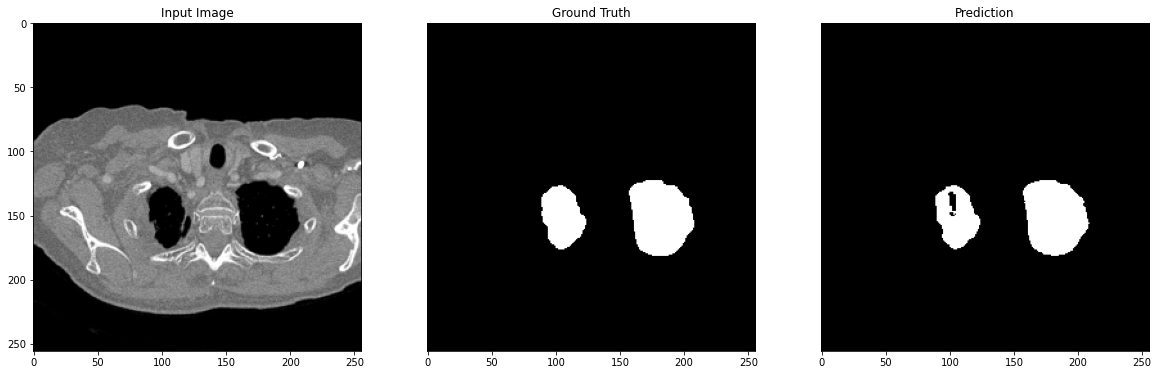

In [28]:
visualize_predictions(0)